# Housing Price Prediction

### Stan Liu

#### 05/10/2018

- #### 1.Introduction
- #### 2.Data exploration and Feature Engineering
    - 2.1 Load data and packages
    - 2.2 Check data Distribution
    - 2.3 Process null and missing values
    - 2.4 Label encoding
    - 2.5 Feature expanding
    - 2.6 Split training and validation set
- #### 3.Model building and training
    - 3.1 Define the model
    - 3.2 Test base model
    - 3.3 Stack model
    - 3.4 Set loss function and optimizer
    - 3.5 Model Training
- #### 4.Emsembling
    - 4.1 Training and validation curves
    - 4.2 Accuracy
    - 4.3 Confusion matrix
- #### 5.Prediction and submition
    - 5.1 Predict single digit
    - 5.2 Submit results

## 1. Introduction

## 2. Data exploration and Feature Engineering Feature Engineering

### 2.1 Load data and packages

In [1]:
#Import necessary packages
import copy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline

#ignore annoying warning (from sklearn and seaborn)

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor


from scipy import stats
from scipy.stats import norm, skew

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV

#Limiting floats output to 3 decimal points

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

In [2]:
#Load the data set

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
testID = test['Id']

### 2.2 Check Data Distribution

In [4]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
numeric_feats = train.dtypes[train.dtypes != "object"].index
correlation = train[numeric_feats].corr()
correlation['SalePrice'].sort_values()[-5:]

GarageArea    0.623
GarageCars    0.640
GrLivArea     0.709
OverallQual   0.791
SalePrice     1.000
Name: SalePrice, dtype: float64

- Then we can find, in all the numeric independent variables, some of them is highly corralated with SalePrice. 

- Then we may try to print out the scatter plot to have a intuitive guide of our analysis.

Text(0.5, 0, 'GarageArea')

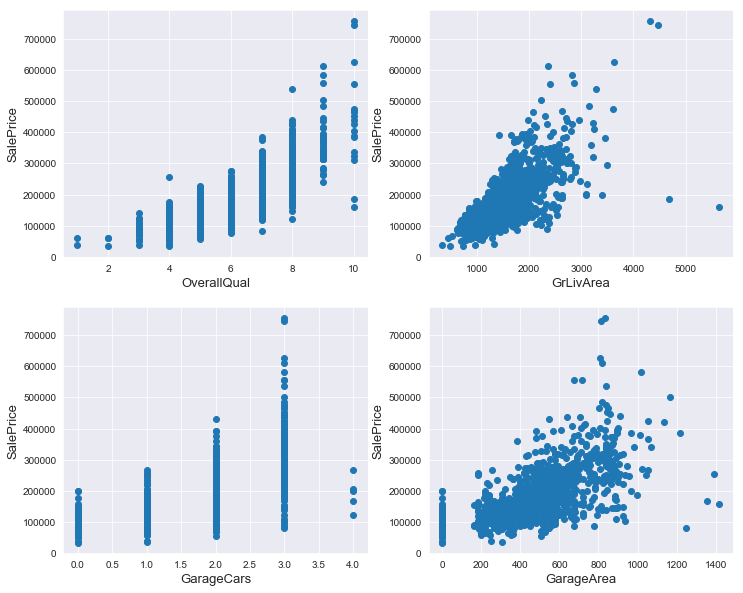

In [7]:
#Draw the Scatter plot of these four variables along with SalePrice.

fig, (ax1,ax2) = plt.subplots(2,2, figsize = (12,10))

ax1 = plt.subplot(221)
ax1.scatter(x = train['OverallQual'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)

ax2 = plt.subplot(222)
ax2.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

ax1 = plt.subplot(223)
ax1.scatter(x = train['GarageCars'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageCars', fontsize=13)

ax1 = plt.subplot(224)
ax1.scatter(x = train['GarageArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageArea', fontsize=13)

- Now we find something like outliears: Some of the samples have an abnormally low price in the data set. These may spoil our model fitting and prediction since they provide error message of the house price.
- Here we chose to drop samples with extremely large GrLivArea and low price and remain the others.
- And we also chose to drop samples with extremely large GarageArea and low price and remain the others.

In [8]:
train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index, inplace = True)
train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<300000)].index, inplace = True)

Text(0.5, 0, 'GarageArea')

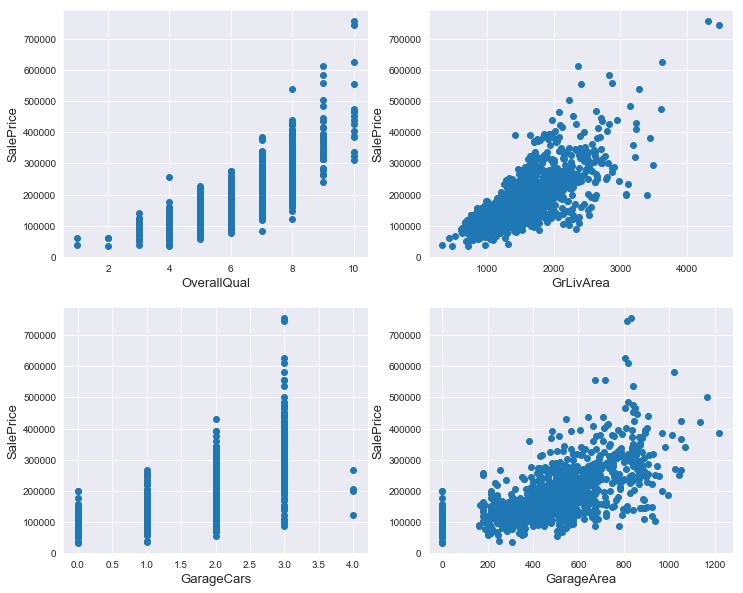

In [9]:
#Now draw Scatter plot of these four variables along with SalePrice again to check the data

fig, (ax1,ax2) = plt.subplots(2,2, figsize = (12,10))

ax1 = plt.subplot(221)
ax1.scatter(x = train['OverallQual'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)

ax2 = plt.subplot(222)
ax2.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

ax1 = plt.subplot(223)
ax1.scatter(x = train['GarageCars'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageCars', fontsize=13)

ax1 = plt.subplot(224)
ax1.scatter(x = train['GarageArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageArea', fontsize=13)

C:\Users\liuse\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 180960.76 and sigma = 79483.16



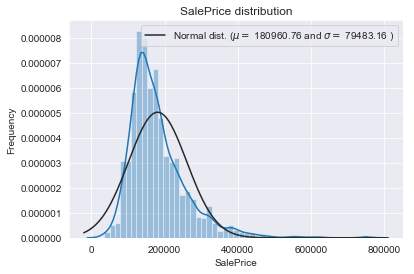

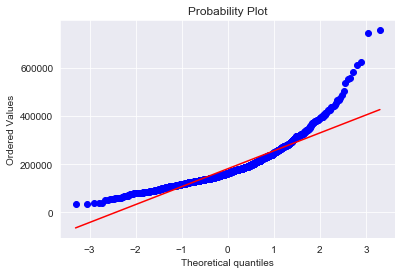

In [10]:
#Now we obatin a relatively normal data set. We can simply print out the distribution of the SalesPrice

sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(np.array(train['SalePrice']), plot=plt)
plt.show()

 - The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.


 mu = 12.02 and sigma = 0.40



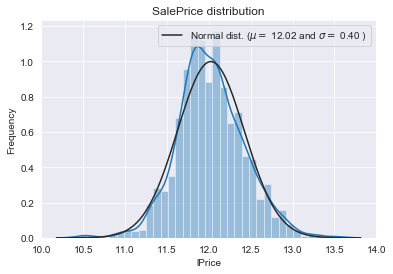

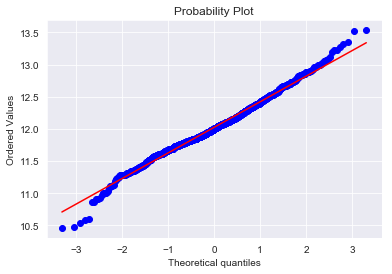

In [11]:
#Now we obatin a relatively normal data set. We can simply print out the distribution of the SalesPrice
train['lPrice'] = np.log(train['SalePrice'].values)

sns.distplot(train['lPrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['lPrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(np.array(train['lPrice']), plot=plt)
plt.show()

 - It looks much better! We nearly obtarined a normally distributed data. Now we can go to data cleansing

### 2.3 Process null and missing values

In [12]:
#We first concatenate the train and test data
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.lPrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.drop(columns = ['Id'], axis = 1, inplace = True)
all_data.drop(columns = ['lPrice'], axis = 1, inplace = True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2914, 79)


In [13]:
#We first check the missing data
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.431
Alley,93.205
Fence,80.405
FireplaceQu,48.696
LotFrontage,16.644
GarageQual,5.456
GarageCond,5.456
GarageFinish,5.456
GarageYrBlt,5.456


 - We now find that most of out sample don't have PoolQC, which could implies they actually don't have a pool. Without being nuissance, we can drop the column and the left data set still make sense.

In [14]:
all_data.drop(['PoolQC'], axis=1, inplace=True)

 - For MiscFeatrue, we fulfill the null with None, which means there's no addition informations

In [15]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

 - For Alley and fence, we all fill the missing value with None. Since this kind of situation means perhaps the house doesn't have alley and fence, it does make sense.

In [16]:
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")

 - For Fireplace, we can also fill the value with None5.

In [17]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

 - For LotFrontage, we know thie value may be similar for houses in a neighbourhood. Thus we group the house by their neighbourhood and use the mid value to fill the NA.

In [18]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

 - There are not too much NA value in the features about Garage, so I just simply full fill all the na value in a simple way.
 - For the qualitative featrues, I simply fullfill the value with NONE
 - For the quantitative features, I simply fullfill the value with 0
 
Since some houses did doesn't have a garage, we tend to think it makes sense

In [19]:
all_data['GarageArea'][all_data['GarageCars'].isnull()] = 0
all_data['GarageCars'][all_data['GarageCars'].isnull()] = 0

In [20]:
Garage_qual = ['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']
for i in Garage_qual:
    all_data[i] = all_data[i].fillna("None")

In [21]:
#It's not easy to deal with year data, we then tend to classify the year data by intrducing interaction term later
all_data["GarageYrBlt"] = all_data.fillna(0)

 - For data about the basement, we adopt the similar strategy to deal with it

In [22]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [23]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

 - For data about the masonry veneer, we adopt the similar strategy.

In [24]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

 - For data about the MSZoning, we adopt the strategy we had ever used in fullfilling the LotFrontage

In [25]:
all_data['MSZoning'] = all_data.groupby("Neighborhood")['MSZoning'].transform(lambda x: x.fillna(x.mode()))
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

 - Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

In [26]:
all_data = all_data.drop(['Utilities'], axis=1)

 - Functional : data description says NA means typical

In [27]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

 - For the rest of the missing value, since the percentage is quite small, we tend to adopt the same stategy for them.

In [28]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

 - Check if there remains any missing values 

In [29]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### 2.4 Label Encoding

In [31]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage',
       'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold',
       'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch',
       'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold'],
      dtype='object')

In [32]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond and OverallQual into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['OverallQual'] = all_data['OverallQual'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


In [33]:
all_data["GarageYrBltx"]=pd.Series()

In [34]:
for index,i in enumerate(all_data["GarageYrBlt"].values):
    all_data["GarageYrBltx"][index] = int(i)    

In [35]:
for i in all_data["GarageYrBltx"][all_data["GarageYrBltx"] > 3000].values:
    i = copy.copy(3000)

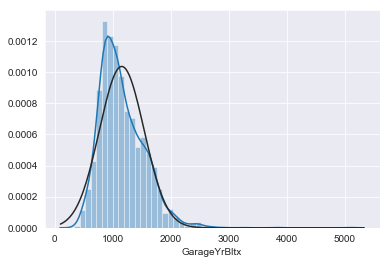

In [36]:
sns.distplot(all_data["GarageYrBltx"] , fit=norm)

 - Then we find the feature GarageYrBlt may contain a lot of noise, perhaps the meaning of the number is not clear. 
 - As a result, we decided to bin it in order to decrease the noise

In [37]:
all_data["GarageYrBltx"][all_data["GarageYrBltx"] > 3000] = 3000

In [38]:
bins_GarageYr = np.linspace(all_data["GarageYrBltx"].min(),all_data["GarageYrBltx"].max(), 11)
which_bin = np.digitize(all_data["GarageYrBltx"], bins=bins_GarageYr)

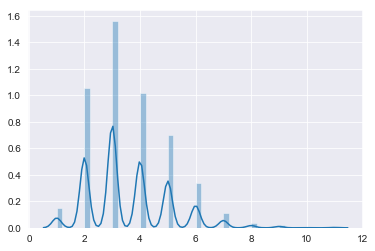

In [39]:
sns.distplot(which_bin)

 - Then we may chose to use the which_bin list to substitute the original GarageYrBlt value

In [40]:
all_data["GarageYrBlt"]= pd.Series()

In [41]:
#Use the binned value of GarageYrBlt for this feature
all_data["GarageYrBlt"] = which_bin

In [42]:
#Drop the continuous value
all_data.drop(columns = ["GarageYrBltx"], axis = 1, inplace = True)

 - Then we encode some catagorical variables which may contain info in their ordering set

In [43]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond','OverallQual')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2914, 77)


### 2.5 Feature expanding

 - Consider normaly, the greatest factor of house price should be the Square Feet, we add a import feature into the feature sets

In [44]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

 - Then we want to do one-hot encoding for all the left catagorical features
 - Also we went to find all the interaction effect

In [45]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2914, 234)


In [46]:
y_train = np.log(train['SalePrice'].values)

In [47]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## 3. Model Building and training

### 3.1 Define the model

 - We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [48]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=0).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

- LASSO Regression :
    - This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

In [49]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

 - Elastic Net Regression :
    - again made robust to outliers

In [50]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

 - Kernel Ridge Regression :

In [51]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

 - Gradient Boosting Regression

In [52]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

 - XGBoost

In [53]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

 - LightGBM

In [54]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### 3.2 Test base models

 - Base model Scores

In [55]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1172 (0.0066)



In [56]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1173 (0.0066)



In [57]:
core = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.753033e-19
  overwrite_a=False)
C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.991221e-18
  overwrite_a=False)
C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.172883e-19
  overwrite_a=False)
C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.768225e-19
  overwrite_a=False)
C:\Users\liu

Kernel Ridge score: 0.1173 (0.0066)



In [58]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1168 (0.0066)



In [59]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1185 (0.0054)



In [60]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1165 (0.0058)



### 3.3 Stacking models

 - Simplest Stacking approach : Averaging base models

 - We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn with our model and also to laverage encapsulation and code reuse (inheritance)

In [61]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

 - Averaged base models score

     - We just average four models here ENet, GBoost, KRR and lasso. Of course we could easily add more models in the mix.

In [62]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.753033e-19
  overwrite_a=False)
C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.991221e-18
  overwrite_a=False)
C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.172883e-19
  overwrite_a=False)
C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.768225e-19
  overwrite_a=False)
C:\Users\liu

 Averaged base models score: 0.2992 (0.2202)



 - We then add a neural network as meta model to see the performance

In [284]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

 - Stacking Averaged models Score

 - To make the two approaches comparable (by using the same number of models) , we just average Enet KRR and Gboost, then we add lasso as meta-model.

In [289]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.691407e-18
  overwrite_a=False)
C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.562146e-18
  overwrite_a=False)
C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.772472e-18
  overwrite_a=False)
C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.248028e-18
  overwrite_a=False)
C:\Users\liu

Stacking Averaged models score: 0.1110 (0.0064)


### 3.4 Ensembling StackedRegressor, XGBoost and LightGBM

In [290]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

 - StackedRegressor:

In [291]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.313594e-19
  overwrite_a=False)
C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.796504e-18
  overwrite_a=False)
C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.029823e-19
  overwrite_a=False)
C:\Users\liuse\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.964450e-19
  overwrite_a=False)
C:\Users\liu

0.07216704197609478


 - XGBoost:

In [292]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07883475247676323


 - LightGBM:

In [293]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07387907167134061


In [294]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07122407363425556


 - Ensemble prediction:

In [296]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

 - Submission

In [300]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

NameError: name 'test_ID' is not defined